介绍回归问题

矢量化加速  
for循环对比线性代数库多线程计算  

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

计时器，记录代码运行时间

In [3]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'


'0.14318 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'


'0.00017 sec'

正态分布

In [6]:
def normal(x, mu, sigma):
    """ 返回概率密度 """
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)


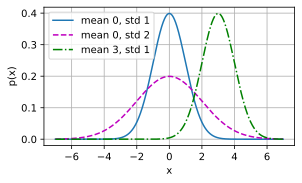

In [7]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])


不使用pytorch的nn库，从0开始搭建线性回归

In [8]:
import random

1.构造数据集  
线性模型加入噪声构造训练数据集  
$Y=Xw+b+Z ，\quad Z \text{～} N(0,00.1)$  
$w=\begin{bmatrix} 2 & -3.4  \end{bmatrix}^T,b=4.2$  
$X_{1000 \times 2}, Y_{1000 \times 1}$

In [9]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))#形状为 (num_examples, len(w))
    y = torch.matmul(X, w) + b #矩阵乘法
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
num_sample=1000
features, labels = synthetic_data(true_w, true_b, num_sample)

In [10]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-2.2393, -0.3931]) 
label: tensor([1.0805])


分别生成两个特征x1,x2和labels的散点图， 可以直观观察到两者之间的线性关系

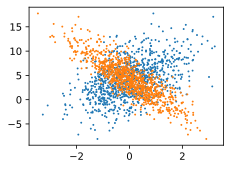

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1);
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

2.数据打乱shuffle与小批量batch_size获取  
(1).可迭代对象(Iterable)：实现了__iter__() 方法的对象(如列表、字典、字符串等)。不支持直接 next(iterable)，但支持 for 循环（因为 for 内部会调用 iter()）。iter()会调用可迭代对象的__iter__方法来返回一个迭代器。先有迭代器，才有可迭代对象。  

(2).iter() 函数的核心作用是将可迭代对象（Iterable）转换为迭代器__iter__()方法会返回可迭代对象对应的迭代器对象，也就是说定义好了一个可迭代对象，必然同时会定义该对象对应的迭代器，分为两种情况，1.可迭代对象本身就是迭代器，实现了next，iter返回自己；2.可迭代对象自身不是迭代器，必须另外给自己定义一个迭代器类，以供__iter__()返回。 

(3).迭代器(Iterator)：通过类实现__iter__() 和__next__()，可以逐个返回元素，自定义复杂迭代逻辑。  

(4).生成器(Generator):通过 yield 定义的函数或表达式，是一种特殊的迭代器，通过 yield 自动实现__iter__() 和__next__()，简洁实现惰性计算。  

(5).yield：创建生成器（Generator）的核心语法，它核心功能是暂停函数执行并返回一个值，同时保留函数的局部状态（如变量值、执行位置等）。下次调用生成器时，会从 yield 后继续执行。  
<pre>可迭代对象（Iterable）  
    ├── 迭代器（Iterator）  
        └── 生成器（Generator）   
        <pre>
生成器用法：  
data=data_iter(10,a,b)  
next(data)  拿取下一批  
for i in data  每次循环取一次数据  
list(data)  全部批次放到list里  

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
#返回的是一个生成器对象（而非函数返回值）


批量大小可以与gpu并行运算能力相匹配，以下可以同时进行计算：  
每一批量的样本  
每个样本的损失函数的梯度  

In [13]:
batch_size = (int)(num_sample/100)
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1644, -1.6247],
        [ 1.1525,  1.1064],
        [-0.5793, -2.0582],
        [-1.1167,  1.2648],
        [ 0.0492, -0.2426],
        [-0.7546, -2.1000],
        [ 1.9117, -0.4641],
        [-1.0526, -0.9360],
        [-0.1032, -0.0216],
        [-1.0039,  0.9184]]) 
 tensor([[ 9.4145],
        [ 2.7559],
        [10.0282],
        [-2.3340],
        [ 5.1196],
        [ 9.8317],
        [ 9.6071],
        [ 5.2803],
        [ 4.0645],
        [-0.9266]])


初始化模型参数  
正态分布中采样随机数来初始化权重  
这些是最终需要求出来的决策变量，需要开启计算图(required_grad)  

In [14]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

更新这些参数，直到这些参数足够拟合我们的数据  
使用梯度下降法来进行迭代  
自动微分来计算梯度

定义模型$Y=Xw+b$    
定义损失函数MSE  
定义优化算法SGD  

In [15]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练  
每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测  
计算完损失后，我们开始反向传播，存储每个参数的梯度  
调用优化算法sgd来更新模型参数  
<pre>初始化参数
重复以下训练，直到完成
    计算梯度
    更新参数<pre>
每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集，   
并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。   
这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。

In [16]:
lr = 0.03
num_epochs = (int)(num_sample/batch_size)
net = linreg
loss = squared_loss

time=d2l.Timer()
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        #print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
print(time.stop())
print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')


3.0544378757476807
epoch 100, loss 0.000050


可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。  
事实上，真实参数和通过训练学到的参数确实非常接近。

In [17]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0002,  0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([-0.0003], grad_fn=<RsubBackward1>)


在机器学习中，我们通常不太关心恢复真正的参数，而更关心如何高度准确预测参数。  
幸运的是，即使是在复杂的优化问题上，随机梯度下降通常也能找到非常好的解。  
其中一个原因是，在深度网络中存在许多参数组合能够实现高度精确的预测。